# Computer vision data

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai import * 
from fastai.vision import * 

This module contains the classes that define datasets handling [`Image`](/vision.image.html#Image) objects and their tranformations. As usual, we'll start with a quick overview, before we get in to the detailed API docs.

## Quickly get your data ready for training

To get you started as easily as possible, the fastai provides two helper functions to create a [`DataBunch`](/data.html#DataBunch) object that you can directly use for training a classifier. To demonstrate them you'll first need to download and untar the file by executing the following cell. This will create a data folder containing a MNIST subset in `data/mnist_sample`.

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
path

PosixPath('/data1/jhoward/git/fastai/fastai/../data/mnist_sample')

The first way to define a [`DataBunch`](/data.html#DataBunch) object requires you to put your data in folders this way (the `test` folder is optional):
```
path\
  train\
    clas1\
    clas2\
    ...
    clasn\
  valid\
    clas1\
    clas2\
    ...
    clasn\
  test\
```
You can then use [`image_data_from_folder`](/vision.data.html#image_data_from_folder):

In [ ]:
data = image_data_from_folder(path, ds_tfms=get_transforms(do_flip=False), size=24)

Here the datasets will be automatically created from the structure above, and we precise:
- the transforms to apply to the images in `ds_tfms` (here with `do_flip`=False because we don't want to flip numbers),
- the target `size` of our pictures (here 24).

As all [`DataBunch`](/data.html#DataBunch), data then as a `train_dl` and a `valid_dl` that are [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). If you want to have a look at a few images in a batch inside a batch, you can use [`show_image_batch`](/vision.data.html#show_image_batch), the `rows` argument being the number of rows and columns in the array.

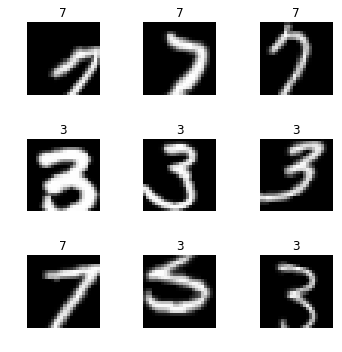

In [ ]:
show_image_batch(data.train_dl, data.train_ds.classes, rows=3, figsize=(5,5))

The second way to define the data for a classifier requires a structure like this:
```
path\
  train\
  test\
  labels.csv
```
where the labels.csv file defines what the label(s) of each image in the training set. This is the format you will need to use when each image can have multiple labels. It also works with single labels:

In [ ]:
pd.read_csv(path/'labels.csv').head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


You can then use [`image_data_from_csv`](/vision.data.html#image_data_from_csv):

In [ ]:
data = image_data_from_csv(path, ds_tfms=get_transforms(do_flip=False), size=28)

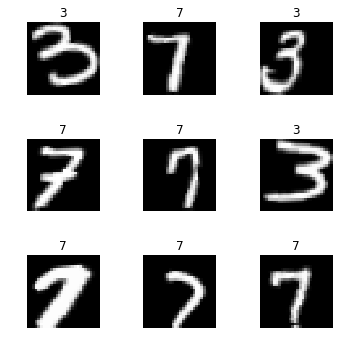

In [ ]:
show_image_batch(data.train_dl, classes=[3,7], rows=3, figsize=(5,5))

An example of multiclassification can be downloaded with the following cell. It's a sample of the [planet dataset](https://www.google.com/search?q=kaggle+planet&rlz=1C1CHBF_enFR786FR786&oq=kaggle+planet&aqs=chrome..69i57j0.1563j0j7&sourceid=chrome&ie=UTF-8).

In [ ]:
planet = untar_data(URLs.PLANET)

If we open the labels files, we seach that each image has one or more tags, separated by a space.

In [ ]:
df =pd.read_csv(planet/'labels.csv')
df.head()

,Unnamed: 0,image_name,tags
0,0,train_21983,partly_cloudy primary
1,1,train_9516,clear cultivation primary water
2,2,train_12664,haze primary
3,3,train_36960,clear primary
4,4,train_5302,haze primary road


In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = image_data_from_csv(planet, folder='train', ds_tfms=tfms, size=128,
                           fn_col=1, lbl_col=2, suffix='.jpg')

The [`show_image_batch`](/vision.data.html#show_image_batch) function wil then print all the labels that correspond to each image.

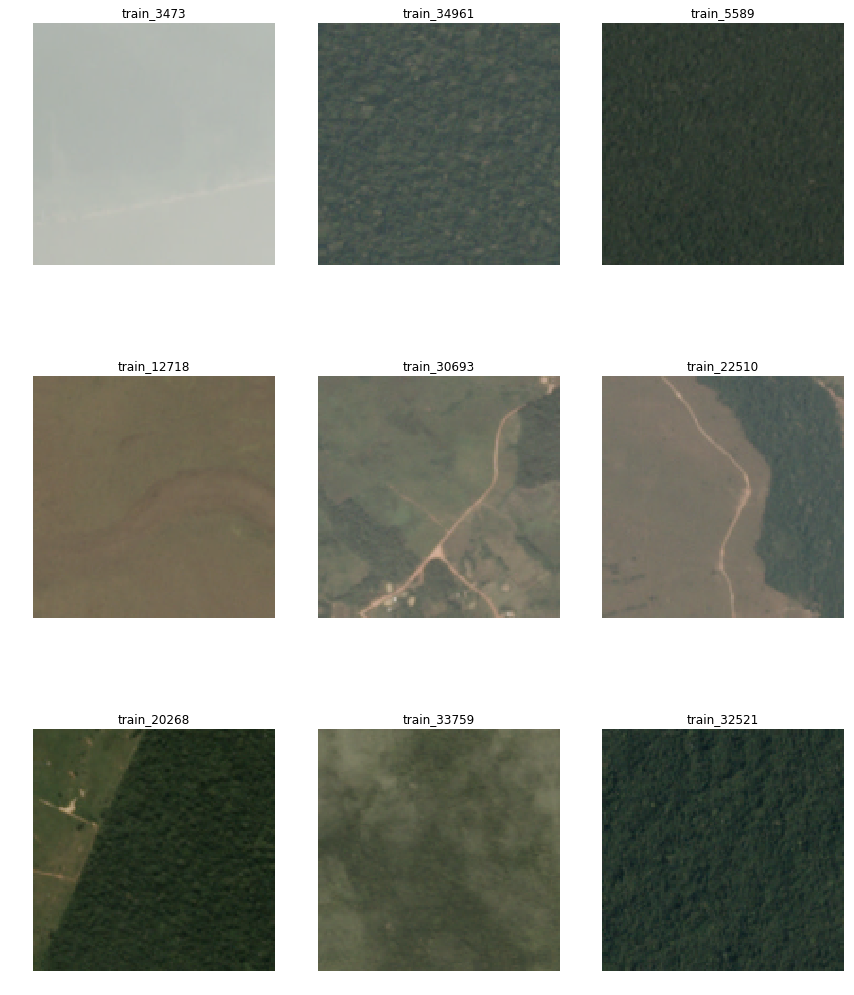

In [ ]:
show_image_batch(data.train_dl, data.train_ds.classes, rows=3)

## Defining a DataBunch

If you quickly want to get a [`DataBunch`](/data.html#DataBunch) and train a model, you should process your data to have it in one of the formats the following functions handle. 

In [ ]:
show_doc(image_data_from_folder)

#### <a id=image_data_from_folder></a>`image_data_from_folder`
> `image_data_from_folder`(`path`:`PathOrStr`, `train`:`PathOrStr`=`'train'`, `valid`:`PathOrStr`=`'valid'`, `test`:`Union`\[`Path`, `str`, `NoneType`\]=`None`, `kwargs`:`Any`) → [`DataBunch`](/data.html#DataBunch)


Create [`DataBunch`](/data.html#DataBunch) from imagenet style dataset in `path` with `train`,`valid`,`test` subfolders.  <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L250">[source]</a>

```
path\
  train\
    clas1\
    clas2\
    ...
    clasn\
  valid\
    clas1\
    clas2\
    ...
    clasn\
  test\
```
Note that the test folder is optional. A few of the kwargs you can pass are:
- `bs`: Desired batchsize for the dataloaders
- `num_workers`: The number of process to launch for data collection
- `ds_tfms`: Tuple of two lists of transforms (first for training and second for validation and test set)
- `size`: Target size for those transforms
- `tfms`: List of transforms to be applied at a batch level (like normalization)
- `device`: The device on which to put the batches

In [ ]:
data = image_data_from_folder(path, ds_tfms=get_transforms(do_flip=False), size=24)

In [ ]:
show_doc(image_data_from_csv)

#### <a id=image_data_from_csv></a>`image_data_from_csv`
> `image_data_from_csv`(`path`:`PathOrStr`, `folder`:`PathOrStr`=`'.'`, `sep`=`None`, `csv_labels`:`PathOrStr`=`'labels.csv'`, `valid_pct`:`float`=`0.2`, `fn_col`:`int`=`0`, `label_col`:`int`=`1`, `test`:`Union`\[`Path`, `str`, `NoneType`\]=`None`, `suffix`:`str`=`None`, `header`:`Union`\[`int`, `str`, `NoneType`\]=`'infer'`, `kwargs`:`Any`) → [`DataBunch`](/data.html#DataBunch)


Create a [`DataBunch`](/data.html#DataBunch) from a csv file.  <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L306">[source]</a>

Create [`DataBunch`](/data.html#DataBunch) from `path` by splitting the data in `folder` and labelled in a file `csv_labels` between a training and valid set, putting aside `valid_pct` for the validation. An optional `test` folder contains unlabelled data and `suff` contains an optional suffix to add to the filenames in `csv_labels` (like '.jpg')

The same list of kwargs as in [`image_data_from_folder`](/vision.data.html#image_data_from_folder) applies here.

In [ ]:
data = image_data_from_csv(path, ds_tfms=get_transforms(do_flip=False), size=24)

In [ ]:
show_doc(image_data_from_df)

#### <a id=image_data_from_df></a>`image_data_from_df`
> `image_data_from_df`(`path`:`PathOrStr`, `df`:`DataFrame`, `folder`:`PathOrStr`=`'.'`, `sep`=`None`, `valid_pct`:`float`=`0.2`, `fn_col`:`int`=`0`, `label_col`:`int`=`1`, `test`:`Union`\[`Path`, `str`, `NoneType`\]=`None`, `suffix`:`str`=`None`, `kwargs`:`Any`) → [`DataBunch`](/data.html#DataBunch)


Create a [`DataBunch`](/data.html#DataBunch) from a DataFrame.  <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L288">[source]</a>

Same as `image_data_from_csv`, but passing in a `DataFrame` instead of a csv file.

In [ ]:
df = pd.read_csv(path/'labels.csv', header='infer')
data = image_data_from_df(path, df, ds_tfms=get_transforms(do_flip=False), size=24)

In both cases, you can have a quick look at your data by using the following function:

In [ ]:
show_doc(show_image_batch, arg_comments={
    'dl': 'A dataloader from which to show a sample',
    'classes': 'List of classes (for the labels)',
    'rows': 'Will make a square of `rows` by `rows` images',
    'figsize': 'Size of the graph shown',
    'denorm': 'Optional function to denormalize the data if it was normalized'
})

#### <a id=show_image_batch></a>`show_image_batch`
> `show_image_batch`(`dl`:[`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), `classes`:`StrList`, `rows`:`int`=`None`, `figsize`:`Tuple`\[`int`, `int`\]=`(12, 15)`, `denorm`:`Callable`=`None`)


Show a few images from a batch. 

- *dl*: A dataloader from which to show a sample
- *classes*: List of classes (for the labels)
- *rows*: Will make a square of `rows` by `rows` images
- *figsize*: Size of the graph shown
- *denorm*: Optional function to denormalize the data if it was normalized <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L40">[source]</a>

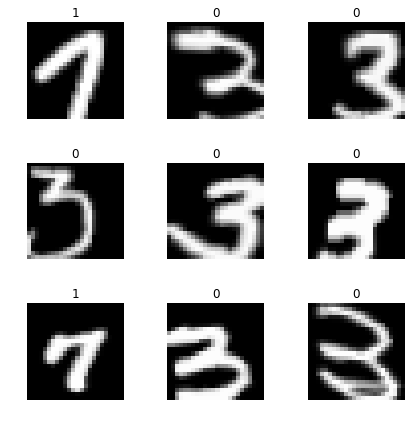

In [ ]:
show_image_batch(data.train_dl, data.train_ds.classes, 3, figsize=(6,6))

Another function that will help visualize a batch is:

In [ ]:
show_doc(show_images, doc_string=False)

#### <a id=show_images></a>`show_images`
> `show_images`(`x`:`Collection`\[[`Image`](/vision.image.html#Image)\], `y`:`int`, `rows`:`int`, `classes`:`StrList`=`None`, `figsize`:`Tuple`\[`int`, `int`\]=`(9, 9)`)
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L49">[source]</a>

Plot a square of `rows` by `rows` images in `x` titled according to `classes[y]` with a total size of `figsize`.

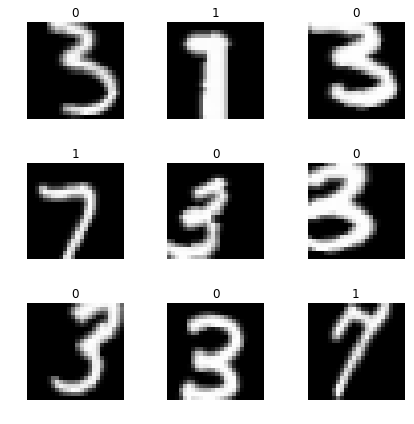

In [ ]:
x,y = next(iter(data.train_dl))
x,y = x.cpu(),y.cpu()
show_images(x, y, 3, data.train_ds.classes, figsize=(6,6))

Both those functions will handle data with single or multi labels.

A last function that is useful if you're in a segmentation task or an object detection task is

In [ ]:
show_doc(show_xy_images, doc_string=False)

#### <a id=show_xy_images></a>`show_xy_images`
> `show_xy_images`(`x`:`Tensor`, `y`:`Tensor`, `rows`:`int`, `figsize`:`tuple`=`(9, 9)`)
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L60">[source]</a>

Plot a square of `rows` by `rows` images in `x` with the corresponding `y` and a total size of `figsize`.

To show an example, we're going to create a fake batch by transforming the same [`Image`](/vision.image.html#Image) several times. See the documentation of [`apply_tfms`](/vision.image.html#apply_tfms) for more details abut what is happening in this code.

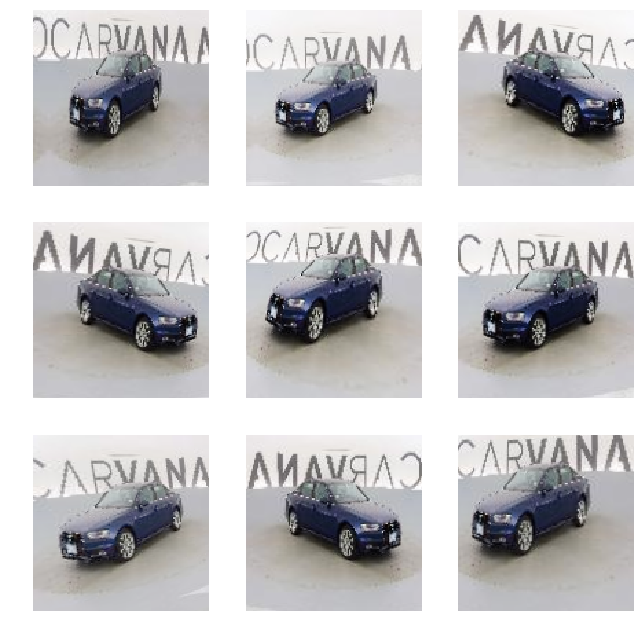

In [ ]:
def get_img_mask(): return open_image('imgs/car_example.jpg'), open_mask('imgs/mask_example.png')

img,mask = get_img_mask()
bs,size = 32,128
tfms = get_transforms()

x,y = torch.zeros(bs,3,size,size), torch.zeros(bs,1,size,size).long()
for i in range(bs):
    img, mask = get_img_mask()
    img = apply_tfms(tfms[0], img, size=size)
    mask = apply_tfms(tfms[0], mask, do_resolve=False, size=size)
    x[i],y[i] = img.data,mask.data

show_images(x, y, 3)

## Data normalization

You may also want to normalize your data, which can be done by using the following functions.

In [ ]:
show_doc(normalize)

#### <a id=normalize></a>`normalize`
> `normalize`(`x`:`Tensor`, `mean`:`FloatTensor`, `std`:`FloatTensor`) → `Tensor`


Normalize `x` with `mean` and `std`.  <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L208">[source]</a>

In [ ]:
show_doc(denormalize)

#### <a id=denormalize></a>`denormalize`
> `denormalize`(`x`:`Tensor`, `mean`:`FloatTensor`, `std`:`FloatTensor`) → `Tensor`


Denormalize `x` with `mean` and `std`.  <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L212">[source]</a>

In [ ]:
show_doc(normalize_funcs, doc_string=False)

#### <a id=normalize_funcs></a>`normalize_funcs`
> `normalize_funcs`(`mean`:`FloatTensor`, `std`:`FloatTensor`) → `Tuple`\[`Callable`, `Callable`\]
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L224">[source]</a>

Create [`normalize`](/vision.data.html#normalize) and [`denormalize`](/vision.data.html#denormalize) functions using `mean` and `std`. `device` will store them on the device specified. `do_y` determines if the target should also be normaized or not.

On MNIST the mean and std are 0.1307 and 0.3081 respectively (looked on Google). If you're using a pretrained model, you'll need to use the normalization that used to train the model. The imagenet norm and denorm functions are stored as constants inside the library named <code>imagenet_norm</code> and <code>imagenet_denorm</code>. If you're training a model on CIFAR-10, you can also use <code>cifar_norm</code> and <code>cifar_denorm</code>.

Note that if you normalize your input, you'll need to denormalize it when using functions like [`show_images`](/vision.data.html#show_images) or [`show_image_batch`](/vision.data.html#show_image_batch). The correct way to look at those pictures is to denormalize them first:

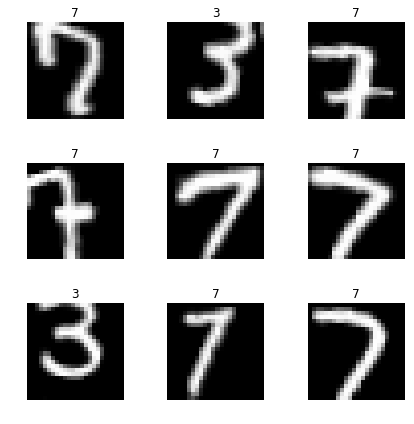

In [ ]:
data = image_data_from_folder('../data/mnist_sample/', ds_tfms=get_transforms(do_flip=False), 
                              tfms=imagenet_norm, size=24)
show_image_batch(data.train_dl, data.train_ds.classes, 3, figsize=(6,6), denorm=imagenet_denorm)

## Datasets

Depending on the task you are tackling, you'll need one of the following fastai datasets.

In [ ]:
show_doc(ImageClassificationDataset, title_level=3)

### <a id=ImageClassificationDataset></a>`class` `ImageClassificationDataset`
> `ImageClassificationDataset`(`fns`:`FilePathList`, `labels`:`StrList`, `classes`:`Optional`\[`Classes`\]=`None`) :: [`ImageDataset`](/vision.data.html#ImageDataset)


[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for folders of images in style {folder}/{class}/{images}.  <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L74">[source]</a>

This is the basic dataset for image classification: `fns` are the filenames of the images and `labels` the corresponding labels. Optionally, `classes` contains a name for each possible label.

In [ ]:
show_doc(ImageClassificationDataset.from_folder)

#### <a id=from_folder></a>`from_folder`
> `from_folder`(`folder`:`Path`, `classes`:`Optional`\[`Classes`\]=`None`, `valid_pct`:`float`=`0.0`, `check_ext`:`bool`=`True`) → `Union`\[`ImageClassificationDataset`, `List`\[`ImageClassificationDataset`\]\]


Dataset of `classes` labeled images in `folder`. Optional `valid_pct` split validation set.  <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L94">[source]</a>

Create an [`ImageClassificationDataset`](/vision.data.html#ImageClassificationDataset) automatically from a `folder`. If `classes` is None, it will be set to the names of the directories in `folder`. `check_ext` forces the function to only keep filenames with image extensions.

In [ ]:
show_doc(ImageClassificationDataset.from_single_folder, doc_string=False)

#### <a id=from_single_folder></a>`from_single_folder`
> `from_single_folder`(`folder`:`PathOrStr`, `classes`:`Classes`, `check_ext`=`True`)
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L88">[source]</a>

Typically used for define a test set. Label all images in `folder` with `classes[0]`. `check_ext` forces the function to only keep filenems with image extensions.

In [ ]:
show_doc(ImageMultiDataset, doc_string=False, title_level=3)

### <a id=ImageMultiDataset></a>`class` `ImageMultiDataset`
> `ImageMultiDataset`(`fns`:`FilePathList`, `labels`:`StrList`, `classes`:`Optional`\[`Classes`\]=`None`) :: [`LabelDataset`](/data.html#LabelDataset)
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L109">[source]</a>

This is the basic dataset for image classification with multiple labels: `fns` are the filenames of the images and `labels` the corresponding labels (may be more than one for each image). Optionally, `classes` contains a name for each possible label.

In [ ]:
show_doc(ImageMultiDataset.from_folder, doc_string=False)

#### <a id=from_folder></a>`from_folder`
> `from_folder`(`path`:`PathOrStr`, `folder`:`PathOrStr`, `fns`:`Series`, `labels`:`StrList`, `valid_pct`:`float`=`0.2`, `classes`:`Optional`\[`Classes`\]=`None`)
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L133">[source]</a>

To create an [`ImageMultiDataset`](/vision.data.html#ImageMultiDataset) automatically in `path` from a `folder` and `fns`. If `classes` is None, it will be set to the names of the different `labels` seen. You can split the images in this `folder` in a train/valid dataset if `valid_pct` is non-zero. `check_ext` forces the function to only keep filenems with image extensions.

In [ ]:
show_doc(ImageMultiDataset.from_single_folder, doc_string=False)

#### <a id=from_single_folder></a>`from_single_folder`
> `from_single_folder`(`folder`:`PathOrStr`, `classes`:`Classes`, `check_ext`=`True`)
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L126">[source]</a>

Typically used for define a test set. Label all images in `folder` with `classes[0]`. `check_ext` forces the function to only keep filenems with image extensions.

To help scan a folder for these [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), we use the following helper function:

In [ ]:
show_doc(get_image_files, doc_string=False)

#### <a id=get_image_files></a>`get_image_files`
> `get_image_files`(`c`:`Path`, `check_ext`:`bool`=`True`) → `FilePathList`
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L17">[source]</a>

Return list of files in `c` that are images. `check_ext` will filter to keep only the files with image extensions.

In [ ]:
show_doc(SegmentationDataset, doc_string=False, title_level=3)

### <a id=SegmentationDataset></a>`class` `SegmentationDataset`
> `SegmentationDataset`(`x`:`Collection`\[`PathOrStr`\], `y`:`Collection`\[`PathOrStr`\]) :: [`DatasetBase`](/data.html#DatasetBase)
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L142">[source]</a>

This is the basic dataset for image sementation: `x` contains the filenames of the images and `y` the ones of the masks.

In [ ]:
show_doc(ObjectDetectDataset, doc_string=False, title_level=3)

### <a id=ObjectDetectDataset></a>`class` `ObjectDetectDataset`
> `ObjectDetectDataset`(`x_fns`:`FilePathList`, `bbs`:`Collection`\[`Collection`\[`int`\]\], `labels`:`StrList`) :: [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L152">[source]</a>

This is the basic dataset for object detection: `x` contains the filenames of the images, `bbs` the corresponding bounding boxes and `labels` their corresponding labels.

In [ ]:
show_doc(get_annotations)

#### <a id=get_annotations></a>`get_annotations`
> `get_annotations`(`fname`, `prefix`=`None`)


Open a COCO style json in `fname` and returns the lists of filenames (with `prefix`), bboxes and labels.  <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L23">[source]</a>

Finally, to apply transformations to [`Image`](/vision.image.html#Image) in a [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), we use this last class.

In [ ]:
show_doc(ImageDataset, title_level=3)

### <a id=ImageDataset></a>`class` `ImageDataset`
> `ImageDataset`(`fns`:`FilePathList`, `y`:`ndarray`) :: [`LabelDataset`](/data.html#LabelDataset)


Abstract [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) containing images.  <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L66">[source]</a>

In [ ]:
show_doc(DatasetTfm, doc_string=False, title_level=3)

### <a id=DatasetTfm></a>`class` `DatasetTfm`
> `DatasetTfm`(`ds`:[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), `tfms`:`Collection`\[[`Transform`](/vision.image.html#Transform)\]=`None`, `tfm_y`:`bool`=`False`, `kwargs`:`Any`) :: [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L180">[source]</a>

Dataset that applies the list of transforms `tfms` to every item drawn. If `tfms` should be applied to the targets as well, `tfm_y` should be True. `kwargs` will be passed to [`apply_tfms`](/vision.image.html#apply_tfms) internally.

Then this last function automatizes the process of creating [`DatasetTfm`](/vision.data.html#DatasetTfm):

In [ ]:
show_doc(transform_datasets, doc_string=False)

#### <a id=transform_datasets></a>`transform_datasets`
> `transform_datasets`(`train_ds`:[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), `valid_ds`:[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), `test_ds`:`Optional`\[[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)\]=`None`, `tfms`:`Optional`\[`Tuple`\[`Collection`\[[`Transform`](/vision.image.html#Transform)\], `Collection`\[[`Transform`](/vision.image.html#Transform)\]\]\]=`None`, `kwargs`:`Any`)
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L200">[source]</a>

Create train, valid and maybe test DatasetTfm from `train_ds`, `valid_ds` and maybe `test_ds` using `tfms`. It should be a tuple containing the transforms for the training set, then for the validation and test set.

## Undocumented Methods - Methods moved below this line will intentionally be hidden

In [ ]:
show_doc(ImageMultiDataset.get_labels)

#### <a id=get_labels></a>`get_labels`
> `get_labels`(`idx`:`int`) → `StrList`
<a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L123">[source]</a>

In [ ]:
show_doc(ImageMultiDataset.encode)

#### <a id=encode></a>`encode`
> `encode`(`x`:`Collection`\[`int`\])


One-hot encode the target.  <a href="https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L117">[source]</a>